In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches

Plot RMSE from cross validation

In [2]:
from plot import plot_error_cv

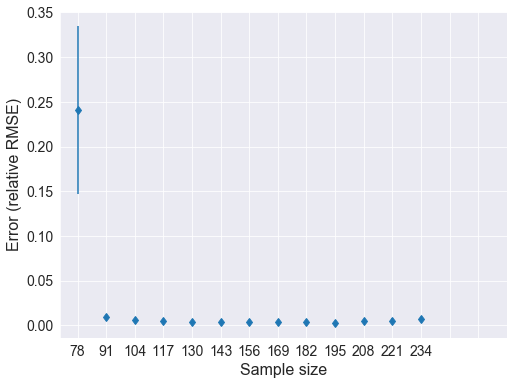

In [3]:
# Plot errors of cross-validation
filepath = '../output/paper/'
filename = 'error_cv_uniform.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
# plot_error_cv(error_stats, save_fig = True, save_path = f'{filepath}figure/', fig_name = filename.split('.')[0])

Bar plot of sensitivity indices

<Figure size 576x432 with 0 Axes>

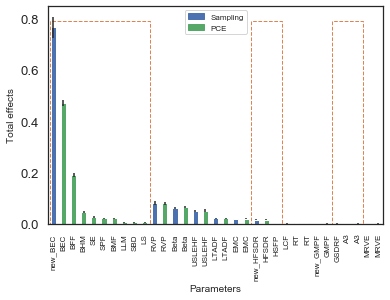

In [13]:
# sensitivity plot
df_plot = pd.read_csv(f'{filepath}sa_fig1_test.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

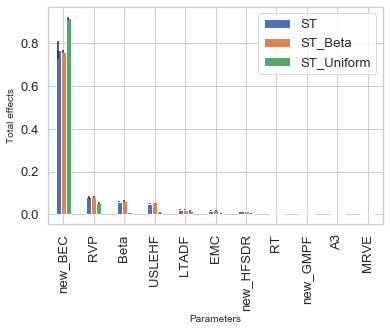

In [12]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig_test.csv', index_col= 'Unnamed: 0')

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=['ST','ST_Beta', 'ST_Uniform' ], kind='bar', 
                yerr=df_plot.loc[:, ['ST_conf','ST_conf_Beta', 'ST_conf_Uniform' ]].T.values, 
                legend=True, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10);         
# plt.savefig(f'{filepath}figure/sentivity_fig2-2.png', format='png', dpi=300, bbox_inches='tight') 


Heat Map plot

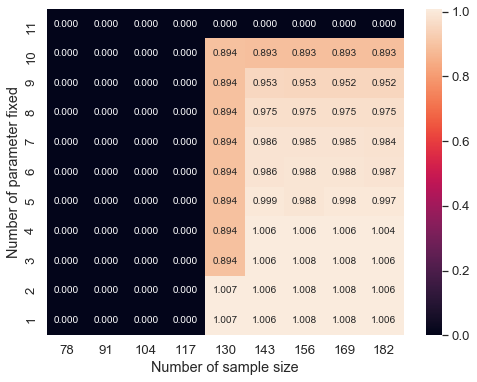

In [5]:
# heat map 
filepath = '../output/paper/error_measures/'
filename = 'conf_width_relative_95.csv'
df = pd.read_csv(f'{filepath}{filename}')
fpath_save = '../output/paper/figure/'
df.drop(columns={'Unnamed: 0'}, inplace=True)
sns.set(font_scale=1.2)
def plot_heatmap(df, save=False, save_name=None):    
    df.index = np.arange(df.shape[0], 0, -1)
    df = df.rename(columns={col: col.split('_')[1] for col in df.columns})
    fig = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(df.loc[:, df.columns[0:-4]], annot=True, fmt=".3f", annot_kws={"size": 10})
    ax.set_xlabel('Number of sample size')
    ax.set_ylabel('Number of parameter fixed')
    if save:
        plt.savefig(f'{fpath_save}{save_name}.png', format='png', dpi=300)
plot_heatmap(df, save=True, save_name=filename.split('.')[0])

Line plot for three error measures

In [21]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper/error_measures/'
filename = ['cf_upper', 'cf_lower', 'cv', 'conf_width_relative_95', 'ks', 'pvalue']
# read statistics from the file y_uncond_stats.json
with open(f'{filepath}y_uncond_stats.json', 'r') as fp: y_uncond_stat = json.load(fp)

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params + 1]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)

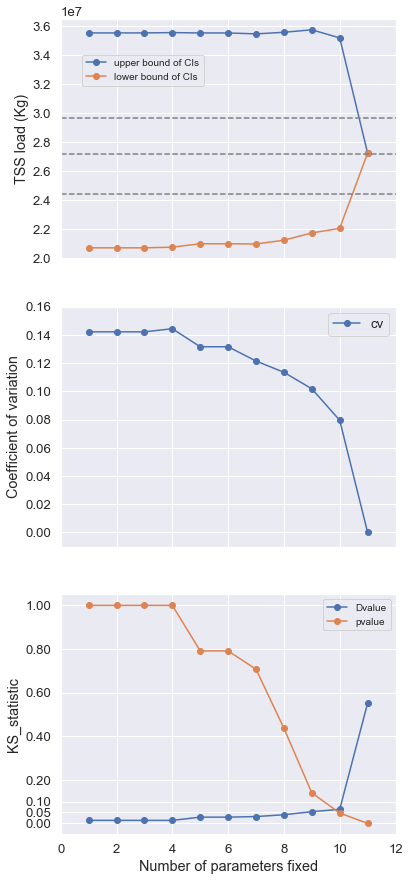

In [46]:
# Line plot
sns.set_style('darkgrid')
fs = 10
fig, axes = plt.subplots(3, 1, sharex=True)
ax = df.plot(x='Num of parameters fixed', y=filename[0:2], 
            figsize=(6, 15), marker='o', ax=axes[0])
# ax.text(0.5, 0.8, '25th percentile of unconditional outputs')             
for i in range(3): ax.axhline(c='grey',linestyle='--', y=list(y_uncond_stat.values())[i])        

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.05, 0.7))
ax1 = df.plot('Num of parameters fixed', filename[2], 
            ax=axes[1], marker='o')
ax1.set_ylim(-0.01, 0.16)        
ax1.set_ylabel('Coefficient of variation')
# ax1.legend(['default', 'average'], fontsize=10)
ax2 = df.plot('Num of parameters fixed',filename[4:], marker='o', ax=axes[2])
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['Dvalue', 'pvalue'], fontsize=fs) ;
ax2.set_xlabel('Number of parameters fixed') ;
plt.savefig(f'{fpath_save}/measures_combine.png', format='png', dpi=300, bbox_inches='tight')

Line plot for showing robustness of error estimation

In [79]:
# Adaptive evaluation of error measure
filepath = '../output/paper/error_measures/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive']

In [80]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename:
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[1]    
cols = df.columns

In [76]:
# filename1 = ['cf_lower_adaptive2', 'cf_lower_lower_adaptive2', 'cf_lower_upper_adaptive2',
#              'cf_upper_adaptive2', 'cf_upper_lower_adaptive2', 'cf_upper_upper_adaptive2']
# # sort the dataframe for plot
# df1 = pd.DataFrame()
# for fn in filename1:
#     df1[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[1]    
# cols1 = df1.columns
# # df1 = df1.rename(columns = {cols1[i]: cols[i] for i in range(len(cols))})
# # df = pd.concat([df, df1])

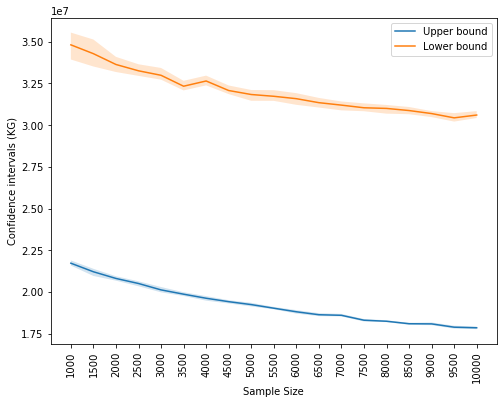

In [127]:
plt.rcParams.update({'font.size': 10})
ax = df[cols[[0, 3]]].plot(figsize=(8, 6))
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.2)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.2)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend(['Upper bound', 'Lower bound'])
plt.savefig('../output/paper/figure/'+'confidence_intervals_adaptive.png', format='png', dpi=300, layout='tight')

In [112]:
ax.get_xticks()

array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ])

In [78]:
pd.read_csv(f'{filepath}{filename[4]}.csv', index_col = 'Unnamed: 0')

,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000
0,2.792025e+07,2.747694e+07,2.707868e+07,2.672005e+07,2.639638e+07,2.610364e+07,2.583836e+07,2.559752e+07,2.537848e+07,2.517894e+07,2.499688e+07,2.483053e+07,2.467831e+07,2.453885e+07,2.441091e+07,2.429341e+07,2.418536e+07,2.408590e+07,2.399424e+07
1,3.393399e+07,3.351508e+07,3.318406e+07,3.295292e+07,3.272547e+07,3.208139e+07,3.238259e+07,3.185975e+07,3.145970e+07,3.145509e+07,3.121810e+07,3.105560e+07,3.088601e+07,3.083340e+07,3.068860e+07,3.065378e+07,3.048275e+07,3.021356e+07,3.042710e+07
2,3.467853e+07,3.370324e+07,3.329916e+07,3.381285e+07,3.312366e+07,3.255155e+07,3.278197e+07,3.211975e+07,3.190856e+07,3.200126e+07,3.188010e+07,3.147626e+07,3.142067e+07,3.143715e+07,3.133802e+07,3.108398e+07,3.096295e+07,3.072812e+07,3.096722e+07
3,3.539872e+07,3.504905e+07,3.451405e+07,3.454215e+07,3.412586e+07,3.363592e+07,3.383507e+07,3.317554e+07,3.302262e+07,3.319047e+07,3.288294e+07,3.256784e+07,3.249985e+07,3.256619e+07,3.238889e+07,3.236037e+07,3.207137e+07,3.193584e+07,3.211142e+07
4,3.524062e+07,3.501922e+07,3.472326e+07,3.469259e+07,3.418345e+07,3.408019e+07,3.389326e+07,3.342008e+07,3.331895e+07,3.327090e+07,3.303292e+07,3.280264e+07,3.265018e+07,3.275030e+07,3.251091e+07,3.244683e+07,3.236287e+07,3.213963e+07,3.222992e+07
5,3.514991e+07,3.542326e+07,3.490162e+07,3.480309e+07,3.458733e+07,3.416426e+07,3.402255e+07,3.347951e+07,3.336636e+07,3.339203e+07,3.308520e+07,3.304829e+07,3.296974e+07,3.301934e+07,3.273900e+07,3.257725e+07,3.244784e+07,3.226811e+07,3.242203e+07
6,3.488970e+07,3.578384e+07,3.528836e+07,3.563155e+07,3.554772e+07,3.562171e+07,3.562683e+07,3.529309e+07,3.547689e+07,3.558951e+07,3.560242e+07,3.562044e+07,3.571770e+07,3.566412e+07,3.555020e+07,3.539494e+07,3.536076e+07,3.522029e+07,3.567555e+07
7,3.472562e+07,3.575449e+07,3.531938e+07,3.568702e+07,3.559189e+07,3.565513e+07,3.572836e+07,3.536328e+07,3.559460e+07,3.576404e+07,3.573485e+07,3.575527e+07,3.593565e+07,3.592764e+07,3.582481e+07,3.569414e+07,3.571528e+07,3.559406e+07,3.604994e+07


In [113]:
df

,cf_lower_adaptive,cf_lower_lower_adaptive,cf_lower_upper_adaptive,cf_upper_adaptive,cf_upper_lower_adaptive,cf_upper_upper_adaptive
1000,2.172545e+07,2.158515e+07,2.189209e+07,3.481277e+07,3.393399e+07,3.554700e+07
1500,2.121285e+07,2.096145e+07,2.139072e+07,3.428278e+07,3.351508e+07,3.513117e+07
2000,2.081174e+07,2.067919e+07,2.094395e+07,3.363547e+07,3.318406e+07,3.409202e+07
2500,2.050914e+07,2.034477e+07,2.064261e+07,3.325713e+07,3.295292e+07,3.364803e+07
3000,2.012644e+07,1.997921e+07,2.029825e+07,3.298764e+07,3.272547e+07,3.342688e+07
3500,1.986922e+07,1.976086e+07,1.998641e+07,3.233323e+07,3.208139e+07,3.265771e+07
4000,1.962503e+07,1.948079e+07,1.975280e+07,3.264668e+07,3.238259e+07,3.296764e+07
4500,1.942014e+07,1.931393e+07,1.950885e+07,3.207530e+07,3.185975e+07,3.237708e+07
5000,1.924510e+07,1.913491e+07,1.935174e+07,3.183582e+07,3.145970e+07,3.210800e+07
5500,1.902885e+07,1.896106e+07,1.910651e+07,3.172975e+07,3.145509e+07,3.209505e+07
